In [5]:
DATA_DIR = '../../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from random import sample
from nilearn import plotting
from nilearn import datasets
from nilearn.input_data import NiftiMasker

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [6]:
imgs = np.load(DATA_DIR + 'binary_imgs.npy')
mask_img = datasets.load_mni152_brain_mask()
masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache')
masker = masker.fit()

## Analysis with 100 PC components

In [7]:
# Calculate 100 PC components
pca = PCA(n_components=100, copy=False)
X_pc = pca.fit_transform(imgs)
    
X_pc.shape

(1401, 100)

In [8]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [9]:
# Mixup implementation
def mixup_data(X, Y, alpha=0.1, mul_factor=10):
    
    rs = np.random.RandomState(39)
    n = X.shape[0]
    
    mixed_X = np.empty((n*(mul_factor-1), X.shape[1]))
    mixed_Y = np.empty((n*(mul_factor-1), Y.shape[1]))
    
    X1_idx = np.empty((n*(mul_factor-1)), dtype=int)
    X2_idx = np.empty((n*(mul_factor-1)), dtype=int)
    lambdas = np.empty((n*(mul_factor-1)))
    
    for i in range(mul_factor-1):
        
        # sample more than needed as some will be filtered out
        lam = np.random.beta(alpha, alpha, size=round(n*1.2))
        
        # original data vectors will be concatenated later
        lam = lam[(lam!=0.0) & (lam!=1.0)][:n][:, None]
        
        shuffle_idx = rs.choice(np.arange(n), n, replace=False)

        mixed_X[i*n : (i+1)*n] = lam * X + (1 - lam) * X[shuffle_idx, :]
        mixed_Y[i*n : (i+1)*n] = lam * Y + (1 - lam) * Y[shuffle_idx, :]
        
        X1_idx[i*n : (i+1)*n] = np.arange(n)
        X2_idx[i*n : (i+1)*n] = shuffle_idx
        lambdas[i*n : (i+1)*n] = lam.reshape(n)
        
    # concatenate original data vectors
    mixed_X = np.append(mixed_X, X, axis=0)
    mixed_Y = np.append(mixed_Y, Y, axis=0)
    
    X1_idx = np.append(X1_idx, np.arange(n), axis=0)
    X2_idx = np.append(X2_idx, rs.choice(np.arange(n), n, replace=False), axis=0)
    lambdas = np.append(lambdas, np.ones(n), axis=0)
            
    return mixed_X, mixed_Y, X1_idx, X2_idx, lambdas

In [14]:
mixed_X, mixed_Y, X1_idx, X2_idx, lambdas = mixup_data(X_pc, Y, alpha=5.0, mul_factor=5)
print(mixed_X.shape)

(7005, 100)


-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.46173224  0.01757734  0.99506471  0.35207074  0.1493463   0.03363363]
Lambda:			 0.4048585989225526
Scores for mixup-ed data: [-0.12027499  0.12959968 -0.08012532 -0.18692238 -0.03045172 -0.2854836 ]


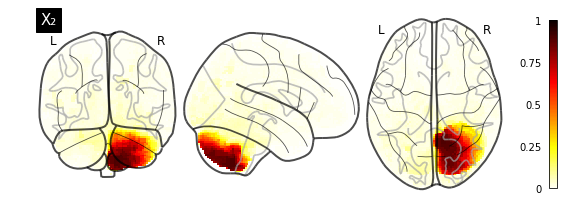

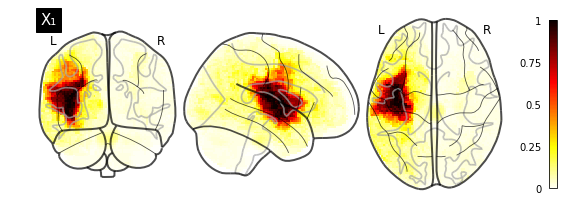

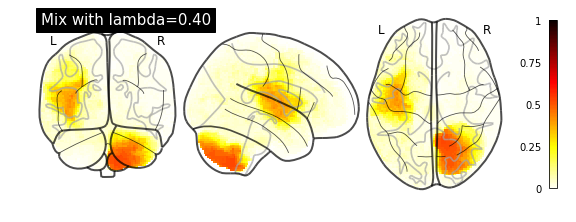

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.04430703  0.29427232 -0.05615677  0.51848475 -0.1641366  -0.58216245]
Lambda:			 0.5019896526925581
Scores for mixup-ed data: [ 0.21365802  0.29427232 -0.86159712 -0.23335823 -0.22970542 -0.66871696]


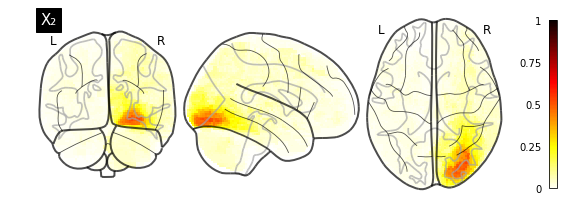

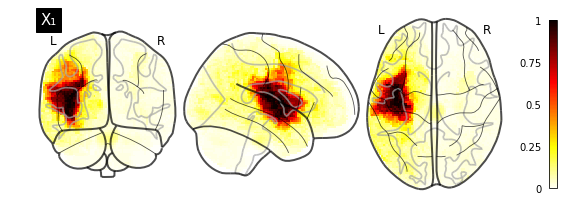

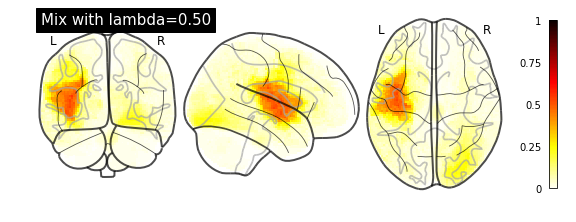

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.29305248 -0.8125076   0.44179025 -0.81282729 -0.08576588  0.77258892]
Lambda:			 0.5156038615681674
Scores for mixup-ed data: [ 0.05483525 -0.2418476  -0.64223745 -0.89863099 -0.19352121 -0.01482803]


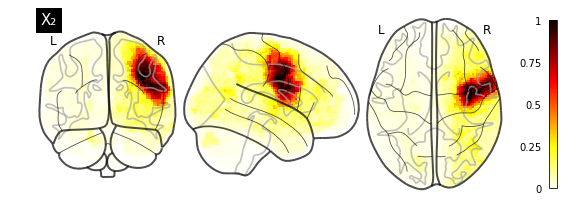

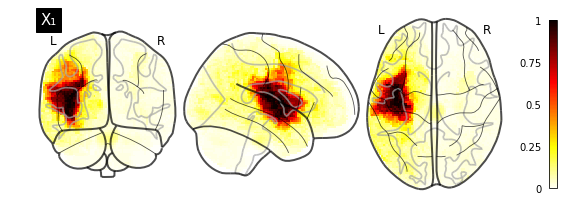

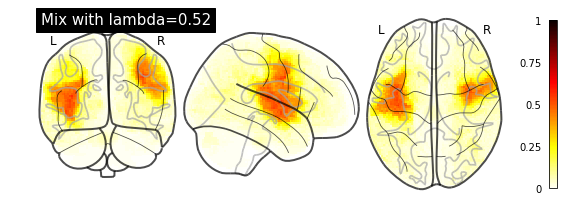

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.79909175 -0.53581262  0.22048046 -0.81282729 -0.34700162 -2.58965765]
Lambda:			 0.6647939004115061
Scores for mixup-ed data: [-0.01413084  0.01602278 -1.03008539 -0.9234583  -0.31226804 -1.36971278]


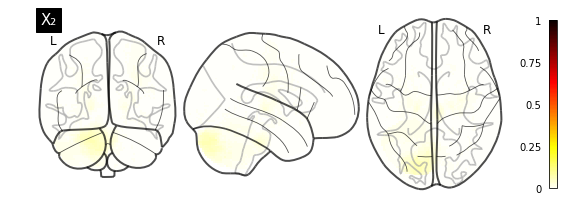

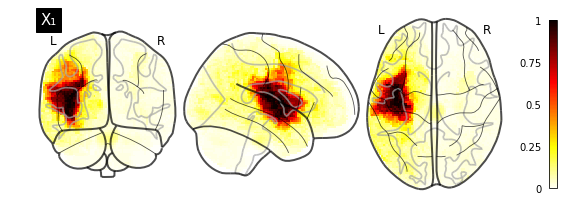

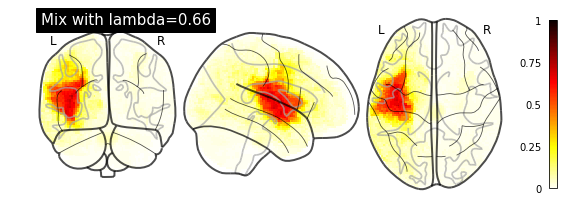

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [0.5503463  1.40105224 0.55244514 0.51848475 0.56732349 0.60016602]
Lambda:			 1.0
Scores for mixup-ed data: [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]


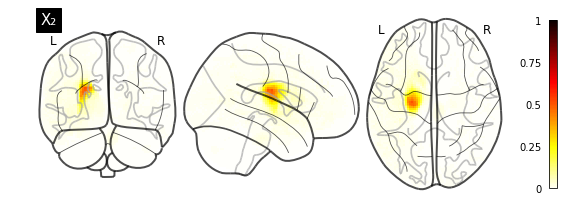

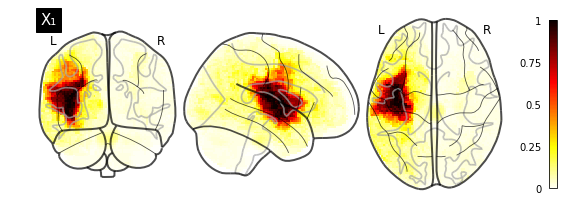

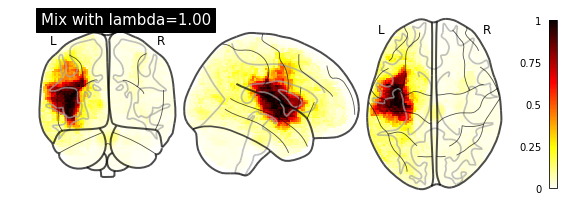

In [15]:
# visualize some samples 

j=0

for p in range(5):
    
    i = 1401*j + 459 # print pairs with sample 459 because #459 is good for visualization.
    print("-------------------------------------------------------------------------------------------------------------\n")
    print("Scores for X\N{SUBSCRIPT ONE}:\t\t", Y[X1_idx[i]])
    print("Scores for X\N{SUBSCRIPT TWO}:\t\t", Y[X2_idx[i]])
    print("Lambda:\t\t\t", lambdas[i])
    print("Scores for mixup-ed data:", mixed_Y[i])
    
    x1_it = masker.inverse_transform(pca.inverse_transform(X_pc[X1_idx[i]]))
    x2_it = masker.inverse_transform(pca.inverse_transform(X_pc[X2_idx[i]]))
    mixed_it = masker.inverse_transform(pca.inverse_transform(mixed_X[i]))
     
    plotting.plot_glass_brain(x2_it, colorbar=True, title="X\N{SUBSCRIPT TWO}", vmin=0, vmax=1)
    plotting.plot_glass_brain(x1_it, colorbar=True, title="X\N{SUBSCRIPT ONE}", vmin=0, vmax=1)
    plotting.plot_glass_brain(mixed_it, colorbar=True, title='Mix with lambda='+"{:.2f}".format(lambdas[i]), vmin=0, vmax=1)
    plt.show()
    j+=1
    

In [11]:
5

5